# **Chapter 1. Hyperparameter Optimization Using a Simple Genetic Algorithm.**

For the hyperparameter search of a simple CNN, a genetic algorithm is utilized, written in python. The concept is based on the article referenced [1], which is accompanied by a Kotlin implementation. The chromosome (gene sequence) of each generation’s individual is considered with a fixed length. Each individual is trained for a fixed number of epochs. The learning rate and the batch size are not optimized with this procedure, as for a fixed size of epochs, the models trained with a small learning rate or a large batch size would obviously have a lower fitness score than the corresponding score of models trained with a higher learning rate or smaller batch size. The population size is taken equal to 20 individuals and the evolution process is repeated for 60 generations. 

The fitness score is computed from the following equation:

$score = \frac{5}{val loss}$

In [ ]:
class GA:
    def __init__ (self, X_train, y_train, model_fun, train_fun, hyperparameters, n_g=10,
                  pop=20, p_mutate=0.2, p_select=0.2, pop_retain=0.5):
        
        from sklearn.model_selection import train_test_split
        import os
        import random
        import time
        
        # Start
        self.start = time.time()
        # Split training set to training and validation set 
        # 80% - 20% split
        self.X_train, self.y_train = X_train, y_train
        # Function that returns the model
        self.model_fun = model_fun
        # Function that trains the model and returns fitness score and model weights
        self.train_fun = train_fun
        # Array with the available hyperparameter values
        # shape: (number of genes, number of gene values)
        self.hyperparameters = hyperparameters
        # Number of generations
        self.n_g = n_g
        # Population 
        self.pop = pop
        # Probability of mutation
        self.p_mutate = p_mutate
        # Probability of selection of an unwanted individual as parent
        self.p_select = p_select
        # Percentage of fittest retained population that passes to the next generation
        self.pop_retain = pop_retain
        # Number of genes, gene values and gene names
        self.n_genes = len(hyperparameters)
        self.values = list(hyperparameters.values())
        self.keys = list(hyperparameters.keys())
        # Initialize models list
        self.models = []
        # Initialize model hyperparameters list
        self.model_pars = []
        # Initialize model scores list
        self.scores = []
        # Initialize id list: generation info of each model
        self.id = []
        # Get file directory and set log.txt path
        self.dir_path = os.getcwd()
        self.log = self.dir_path + '/log.txt'
        # Optimize
        best_scores = []
        for i in range(n_g):
            if i == 0:
                # Initialize the population
                self.init_pop()
                # Train all models on initialization
                self.n_train = pop
            else:
                # Evolve to the next generation
                self.evolve()

            # Train and evaluate models to get new_models and new_scores lists
            # n_trained: the already trained models from previous generation
            # n_train: models to be trained - the children of the previous generation
            n_trained = self.pop - self.n_train
            new_models, new_scores = self.train_models(self.model_fun, self.train_fun, 
                                                       self.X_train, self.y_train, self.model_pars[n_trained:])
            # The new generation (children of previous generation) get a new id
            new_id = self.n_train * [i+1]
            # Add new generations' models, scores and ids to the 
            # corresponding lists
            self.models.extend(new_models)
            self.scores.extend(new_scores)
            self.id.extend(new_id)
            # Add generation's info to log file
            info = []
            # First row contains generation info
            info.append(["GENERATION", i+1])
            # Second row contains the keys
            keys = ["Gen.", "Score"] + self.keys
            info.append(keys)
            # The next rows contain the id, score and hyperparameters of each model
            values = []
            for individual in range(self.pop):
              ind_values = [self.id[individual]] + [self.scores[individual]] + list(self.model_pars[individual].values())
              values.append(ind_values)
            info.extend(values)
            # Use list2text function to save the info to log.txt
            self.list2text(self.log, info, two_dim = True, fun = self.fun)
            # Keep track of generation's best score
            best_scores.append(max(self.scores))
            # Print basic info in the console
            print("\nGENERATION", i+1)
            print("\nBest Score:", max(self.scores))
        # Plot generations' scores figure
        name = self.dir_path + '/gen_scores.png'
        self.plot_figure(best_scores, name)
        # Sort lists
        sorted_list = sorted(zip(self.model_pars, self.scores, 
                                 self.models, self.id),
                                 reverse = True, key=lambda pair: pair[1])
        self.model_pars = [x for x,_,_,_ in sorted_list]
        self.scores = [y for _,y,_,_ in sorted_list]
        self.models = [z for _,_,z,_ in sorted_list]
        self.id = [i for _,_,_,i in sorted_list]
        # Best model
        self.best_model = self.models[0]
        # End
        self.end = time.time()
        self.time = self.end - self.start

    def init_pop (self):
        """
        Generate the chromosomes of initial population: initialize models with 
        random genes.
        """
        for ind in range (0, self.pop):
          # Chromosome of each individual
          chromosome = []
          for gene in range(0, self.n_genes):
            # Pick random gene value
            gene_values = self.values[gene]
            chromosome.append(random.choice(gene_values))         
          # Convert chromosome to dictionary
          chromosome = {self.keys[i]: chromosome[i] for i in range(len(self.keys))}
          # Append to list containing every m
          self.model_pars.append(chromosome)
    
    def train_models (self, model_fun, train_fun, X_train, y_train, model_pars):
      """
      This function uses the input train function, to train all the models with 
      the parameters included in the model_pars list.
      """
      model_list = []
      scores_list = []
      n = len(model_pars)
      for i in range(n):
        model = model_fun(model_pars[i])
        print("\nTraining Model", i+1)
        trained_model, score = train_fun(model,
                            X_train,
                            y_train)
        score = round(score, 2)
        model_list.append(trained_model)
        scores_list.append(score)
      return model_list, scores_list 
        
    def breed (self, father, mother):
        """
        Compute offsprings of 2 models, randomly selected from the fittest 
        individuals list. We practically pick up genes from the mother and 
        the father randomly to compute the childrens' gene sequences. 
        The choice is random in order to retain diversity in the population. 
        Children inherit characteristics from both their parents.
        """
        childrens = []
        father_genes = list(father.values())
        mother_genes = list(mother.values())
        for i in range(2):
            chromosome = []
            for gene in range(0, self.n_genes):
                # Pick a gene randomly from father or mother
                chromosome.append(random.choice([father_genes[gene],
                                             mother_genes[gene]]))
            # Convert chromosome to dictionary
            chromosome = {self.keys[i]: chromosome[i] for i in range(len(self.keys))}
            # Mutation
            if (self.p_mutate > random.random()):
                chromosome = self.mutate(chromosome)
            # Append to list containing every model's chromosome dictionary
            childrens.append(chromosome)
        return childrens

    def mutate (self, chromosome):
        """
        Mutate the parameters of a child:
        mutation means to swap a gene (one of the hyperparameters) with any 
        of the possible values available for that gene.
        """
        # Choose any random gene that will be mutated
        randomGene = random.randint(0, len(self.values)-1)
        # Choose any random value for that parameter ( chosen above )
        chromosome[randomGene] = random.choice(self.values[randomGene])
        return chromosome

    def evolve(self):
        """
        For a given the population:
            1. Sort the members according to their accuracy (descending order).
            2. The top K individuals with the highest fitness scores are added in 
                a separate list called parents. Here ‘K’ is the retainLength.
            3. Randomly add other individuals, with lower fitness scores. 
                This increases diversity as ‘weaker’ parents are passed in the next 
                generation too.
            4. Select two individuals randomly from parents list and check that 
                they are not the same. 
                Call breed() on them and append their children to children list.
            5. Append the children to the parents list.
        """
        # Sort model_pars, scores and model_weights list according to score 
        # in descending order
        sorted_list = sorted(zip(self.model_pars, self.scores, 
                                 self.models, self.id),
                                 reverse = True, key=lambda pair: pair[1])
        self.model_pars = [x for x,_,_,_ in sorted_list]
        self.scores = [y for _,y,_,_ in sorted_list]
        self.models = [z for _,_,z,_ in sorted_list]
        self.id = [i for _,_,_,i in sorted_list]
        # Compute number of retained individuals 
        self.n_retain = int (self.pop_retain * self.pop)
        parents = self.model_pars[:self.n_retain]
        # Add other unselected individuals with a probability p_select
        for unselected in self.model_pars[self.n_retain:]:
            if (self.p_select > random.random()):
                parents.append(unselected)
        # Number of parents
        n_parents = len(parents)
        # Keep the n_retain items of each list
        self.scores = self.scores[:n_parents]
        self.models = self.models[:n_parents]
        self.id = self.id[:n_parents]
        # model_pars contain the parents list and the children list
        self.model_pars = parents
        # Number of children is equal to the population size minus number of parents
        n_children = self.pop - n_parents
        # Number of models to be trained is equal to the number of children
        self.n_train = n_children
        # Compute children list
        children = []
        while (len(children) < n_children):
            # Randomly select 2 different individuals from parents list
            couple = random.sample(parents, 2)
            father = couple[0]
            mother = couple[1]
            # Call breed function
            child_1, child_2 = self.breed(father, mother)
            # Append to children list
            children.append(child_1)
            children.append(child_2)
        # Append n_children to model parameters list
        # (children's list contains even number of individuals
        # pick the first n_children)
        self.model_pars.extend(children[:n_children])
    
    
    def fun(self, x):
        # Convert to str and center text (20chars)
        return f"{str(x) : ^20}"
    
    def list2text (self, path, output, two_dim = False, fun = str):
        """
        This function writes a list to a file.
            - path: the file path
            - output: the list
            - two_dim: True if the list is two dimensional 
                    (contains two lists - one for each dimension)
            - fun: the function processing the list values
                    (str default function for converting all values to
                     string type first)
            """
        # Open file for reading and appending
        dataFile_id = open(path, 'a+')
        if two_dim == True:
            # If list has two dims, iterate for each row
            for row in range(len(output)):
                s = " ".join(map(fun, output[row]))
                dataFile_id.write(s + '\n')
        else:
            # If list contains a row
            # Use map function to apply fun function to each of the list's item
            # and then join the strings into one
            s = " ".join(map(fun, output))
            dataFile_id.write(s + '\n')
        # Close file
        dataFile_id.close()
    
    def plot_figure(self, y, path):
      x = np.arange(1, len(y)+1, step=1)
      plt.figure(figsize=(8, 8))
      plt.title("GENERATIONS' SCORES")
      plt.xlabel("Generation")
      plt.ylabel("Fitness Score")
      plt.xticks(np.arange(0, len(y)+1, step=1))
      plt.plot(x, y)
      plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)
      plt.savefig(path, dpi = 300)
      plt.show()    

# **Toy Example**

The learning rate and batch size were considered equal to 0.001 and 32 respectively for the assessment of the optimal model using the genetic algorithm.



In [ ]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, MaxPool2D, Conv2D, Dropout, Dense, Flatten
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
import time
import random

In [ ]:
# Load MNIST Dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

########## Preprocessing ##########
# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)
X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# **Model & Train Functions**

The 'model' and 'train' function, given as an input to the genetic algorithm, have the following format:

- The 'model' function takes as argument the 'parameters' dictionary that contains the hyperparameters of an individual and returns the model.

- The 'train' function takes as arguments the model, X_train, y_train, batch size and the learning rate and returns the trained model and its fitness score.

# **Hyperparameter Space**

The hyperparameter space for this toy example is the following:

- Number of filters of the first Conv2D layer (filter_num_1) $ \in [4, 8, 16, 32, 64]$

- Filter size of the first Conv2D layer (filter_size_1) $ \in [4, 5, 6]$

- Pool size of the first Pool2D layer (pool_size_1) $ \in [2, 3] $

- Number of filters of the second Conv2D layer (filter_num_2) $ \in [32, 64, 96, 128, 256]$

- Filter size of the second Conv2D layer (filter_size_2) $ \in [2, 3, 4]$

- Pool size of the second Pool2D layer (pool_size_2) $ \in [2, 3]$

- dropout_rate $ \in [0.10, 0.20, 0.30, 0.40, 0.50]$

- activations $ \in [relu, elu, selu, tanh]$

In [ ]:
### Model function ###

def mnist_model(parameters):
  
  # Get hyperparameters from parameters dictionary
  filter_num_1 = parameters.get("Conv 1 Filters")
  filter_size_1 = parameters.get("Conv 1 Filter Size")
  pool_size_1 = parameters.get("Pool 1 Size")
  filter_num_2 = parameters.get("Conv 2 Filters")
  filter_size_2 = parameters.get("Conv 2 Filter Size")
  pool_size_2 = parameters.get("Pool 2 Size")
  act_fun = parameters.get("Activation Fun.")
  dropout_rate = parameters.get("Dropout Rate")

  model = Sequential()
  model.add(Input(shape=(28, 28, 1)))
  model.add(Conv2D(filter_num_1, kernel_size=[filter_size_1, filter_size_1], activation=act_fun))
  model.add(MaxPool2D(pool_size=[pool_size_1, pool_size_1]))
  model.add(Conv2D(filter_num_2, kernel_size=[filter_size_2, filter_size_2], activation=act_fun))
  model.add(MaxPool2D(pool_size=[pool_size_2, pool_size_2]))
  model.add(Flatten())
  model.add(Dropout(dropout_rate))
  model.add(Dense(10, activation="softmax"))

  return model

### Model train function ###

def train_mnist(
        model,
        X_train,
        y_train,
        batch = 32,
        lr = 0.001,
        n_epochs=2):
    """
    This function trains the model and evaluates using validation set 
    or uses 20% of training data with accuracy as the metric.
    """
    start = time.time()
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    history = model.fit(
        X_train,
        y_train,
        epochs=n_epochs,
        batch_size=batch,
        validation_split=0.2)
    end = time.time()
    total_time = end - start
    val_error = history.history['val_loss'][-1]
    fit_score = 5/val_error
    print("Model Training and Validation time %s secs" % (total_time))
    return model, fit_score

In [ ]:
# Example
p = {"Conv 1 Filters": 32, "Conv 1 Filter Size": 6,
      "Pool 1 Size": 3, "Conv 2 Filters": 64, "Conv 2 Filter Size": 4,
      "Pool 2 Size": 3, "Activation Fun.": 'relu', "Dropout Rate": .5}

example = mnist_model(p)
example.summary()

trained_example, fit_score = train_mnist(example, X_train, y_train)

print('Fitness Score = ', fit_score)

Model: "sequential_142"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_269 (Conv2D)          (None, 23, 23, 32)        1184      
_________________________________________________________________
max_pooling2d_257 (MaxPoolin (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_270 (Conv2D)          (None, 4, 4, 64)          32832     
_________________________________________________________________
max_pooling2d_258 (MaxPoolin (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_124 (Flatten)        (None, 64)                0         
_________________________________________________________________
dropout_124 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_124 (Dense)            (None, 10)             

# **Evolution Time!!!**


Training Model 1
Epoch 1/2
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4542 - accuracy: 0.8658 - val_loss: 0.1577 - val_accuracy: 0.9547
Epoch 2/2
1500/1500 [==============================] - 4s 2ms/step - loss: 0.2052 - accuracy: 0.9379 - val_loss: 0.1235 - val_accuracy: 0.9625
Model Training and Validation time 8.140781164169312 secs

Training Model 2
Epoch 1/2
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2005 - accuracy: 0.9403 - val_loss: 0.0757 - val_accuracy: 0.9775
Epoch 2/2
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0776 - accuracy: 0.9767 - val_loss: 0.0589 - val_accuracy: 0.9827
Model Training and Validation time 8.777683973312378 secs

Training Model 3
Epoch 1/2
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2811 - accuracy: 0.9200 - val_loss: 0.0896 - val_accuracy: 0.9737
Epoch 2/2
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0914 - accuracy: 0.9711 - val_loss: 0.

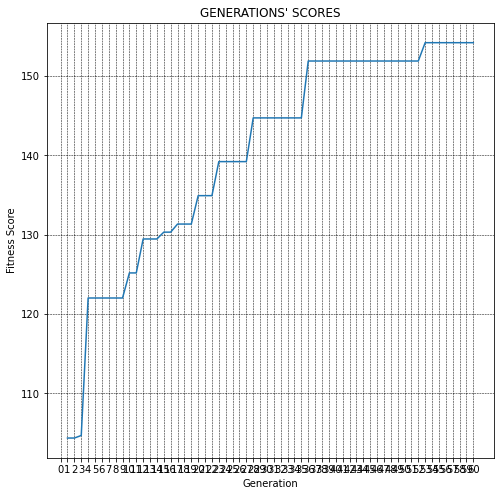

Duration: 4639.673212051392 s
Model: "sequential_1927"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3839 (Conv2D)         (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_3827 (MaxPooli (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3840 (Conv2D)         (None, 9, 9, 256)         131328    
_________________________________________________________________
max_pooling2d_3828 (MaxPooli (None, 3, 3, 256)         0         
_________________________________________________________________
flatten_1909 (Flatten)       (None, 2304)              0         
_________________________________________________________________
dropout_1909 (Dropout)       (None, 2304)              0         
_________________________________________________________________
dense_1909 (Dense)   

In [ ]:
# Use the genetic algorithm to find the optimal hyperparameters
activations = np.array(["relu", "elu", "selu", "tanh"])
dropout_rate = np.array([0.10, 0.20, 0.30, 0.40, 0.50])
filter_num_1 = np.array([4, 8, 16, 32, 64], dtype = int)
filter_size_1 = np.array([4, 5, 6])
pool_size_1 = np.array([2, 3])
filter_num_2 = np.array([32, 64, 96, 128, 256])
filter_size_2 = np.array([2, 3, 4])
pool_size_2 = np.array([2, 3])

# Hyperparameters dictionary
hyperparameters = {"Conv 1 Filters": filter_num_1, "Conv 1 Filter Size": filter_size_1,
                   "Pool 1 Size": pool_size_1, "Conv 2 Filters": filter_num_2, "Conv 2 Filter Size": filter_size_2,
                   "Pool 2 Size": pool_size_2, "Activation Fun.": activations, "Dropout Rate": dropout_rate}

# Model and train functions
model_fun = mnist_model
train_fun = train_mnist
# Run the optimization
opt = GA(X_train, y_train, model_fun, train_fun, hyperparameters, n_g=60,
                  pop=20, p_mutate=0.2, p_select=0.2, pop_retain=0.5)
# Print time duration
print("Duration:", opt.time, 's')
# Best model
best_model = opt.best_model
# Best model summary
best_model.summary()
# Plot best model
plot_model(best_model, to_file='best_model.png')
# Evaluate best model
history = best_model.evaluate(X_test, y_test)

# **References**

- [1] https://heartbeat.fritz.ai/hyperparameter-optimization-with-genetic-algorithms-in-kotlin-75e9c5a1e5ab